# Neural Networks

In [21]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat

%matplotlib inline

## Visualize the data

In [2]:
def ndarray_description(x):
    return "shape: {}, min: {}, max: {}".format(x.shape, x.min(), x.max())

In [5]:
datafile = 'data/ex4data1.mat'
mat = loadmat(datafile)
X, y = mat['X'], mat['y']

# insert column of ones
X = np.insert(X, 0, 1, axis=1)

print("X", ndarray_description(X))  # 5000 images with 400 pixels (20x20)
print("y", ndarray_description(y))  # Labeled classification 1-10, 10 represents 0

X shape: (5000, 401), min: -0.13196323019852488, max: 1.127688299158888
y shape: (5000, 1), min: 1, max: 10


(-0.5, 399.5, 19.5, -0.5)

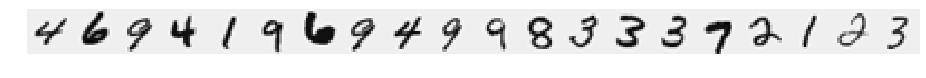

In [6]:
sample = np.random.choice(X.shape[0], 20)  # 20 row indices from X

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(X[sample, 1:].reshape(-1,20).T, cmap='gray_r')  # 0 index is 1 constant
ax.axis('off')

In [9]:
weights = loadmat('data/ex4weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [19]:
theta1, theta2 = weights['Theta1'], weights['Theta2']
print("theta1", ndarray_description(theta1))
print("theta2", ndarray_description(theta2))

params = np.r_[theta1.ravel(), theta2.ravel()]  # quick way to create an array
print("params", ndarray_description(params))    # flattened vector of all params

theta1 shape: (25, 401), min: -1.463369318005054, max: 1.0089920104197974
theta2 shape: (10, 26), min: -4.030847527504247, max: 3.2115848427114373
params shape: (10285,), min: -4.030847527504247, max: 3.2115848427114373


## Feed Forward and Cost functions

### Sigmoid gradient
#### $$ g'(z) = g(z)(1 - g(z))$$
where $$ g(z) = \frac{1}{1+e^{-z}}$$

In [35]:
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

In [36]:
def sigmoid_gradient(z):
    return (sigmoid(z) * (1-sigmoid(z)))

### Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [57]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]  # 5000
    a1 = X          # 5000x401
    
    z2 = theta1.dot(a1.T)  # 25x401 * 401x5000 = 25x5000
    a2 = np.insert(sigmoid(z2.T), 0, values=np.ones(m), axis=1) # 5000x26
    
    z3 = theta2.dot(a2.T)  # 10x26 * 26x5000 = 10x5000
    a3 = sigmoid(z3)  # 10x5000
    
    return a1, z2, a2, z3, a3

In [94]:
def cost(params, input_layer_size, hidden_layer_size, num_labels, X, y, learning_rate):
    # reshape params into arrays for each layer
    theta1 = params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, (input_layer_size+1))
    theta2 = params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, (hidden_layer_size+1))
    
    m = X.shape[0]  # 5000
    y_matrix = pd.get_dummies(y.ravel()).values  # ndarray (5000, 10)
    
    # forward propagate
    a1, z2, a2, z3, a3 = forward_propagate(X, theta1, theta2)
    
    # cost calculation, sums 5000x10 arrays
    J = -1*(1/m) * np.sum((np.log(a3.T)*(y_matrix) + np.log(1-a3).T*(1-y_matrix))) # scalar
    
    # regulation term
    reg = (learning_rate/(2*m)) * ( np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])) )  # scalar
    
    # d - error of each node
    d3 = a3.T - y_matrix  # 5000x10
    d2 = theta2[:, 1:].T.dot(d3.T) * sigmoid_gradient(z2)  # 25x10*10x5000 .* 25x5000 = 25x5000
    
    # deltas - accumulate all node's d for total error
    delta1 = d2.dot(a1)    # 25x5000*5000x401 = 25x401
    delta2 = d3.T.dot(a2)  # 10x5000*5000x26  = 10x26
    
    # replace first coumn of theta values with 1
    # c_ creates arrays with columns
    theta1_ = np.c_[np.ones((theta1.shape[0], 1)), theta1[:, 1:]]
    theta2_ = np.c_[np.ones((theta2.shape[0], 1)), theta2[:, 1:]]
    
    # compute gradients for theta
    theta1_grad = delta1/m + (theta1_*reg)/m
    theta2_grad = delta2/m + (theta2_*reg)/m
    
    return J, theta1_grad, theta2_grad

In [95]:
J, theta1_grad, theta2_grad = cost(params, 400, 25, 10, X, y, 0)

In [96]:
J

0.28762916516131887